In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import math
#import pandas as pd
import itertools
import os
#import ROOT
import datetime
#from root_numpy import root2array, root2rec, tree2rec, array2root
from scipy.optimize import curve_fit
from scipy.misc import factorial


In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
from decode import GetWaveforms
from decode_new import GetWaveformsNoiseRemoval
from analyze import det_baseline, integral, QaQc, QaQcSTATS, mean_plot, gettime

In [4]:
PATH = '/home/david/data/PrM/Gas07psi_092718/'


In [5]:
dt = 0.0005
RC=0.240

In [6]:
PATH_V = ['/home/david/data/PrM/Gas07psi_092718/','/home/david/data/PrM/Gas05psi_092918/',\
         '/home/david/data/PrM/15psi/data/','/home/david/data/PrM/3psi/data3psi/data/',\
          '/home/david/data/PrM/7psi/data7psi/data/']

Qa_avg_v_v = []
Qa_rms_v_v = []
Qc_avg_v_v = []
Qc_rms_v_v = []
int_cat_v_v=[]
int_an_v_v=[]

In [7]:
for PATH in PATH_V:
    
    datafile_v = os.listdir(PATH)
    datafile_v.sort()
    print 'There are %i files'%len(datafile_v)
    
    Qa_avgwf_v = []
    Qc_avgwf_v = []
    
    int_cat_v=[]
    int_an_v=[]
    
    Qa_avg_v = []
    Qa_rms_v = []
    Qc_avg_v = []
    Qc_rms_v = []

    for datafile in datafile_v:
        if (datafile.find('.dat') > 0):

            #print(datafile)
            if (datafile.find('.dat') < 0): continue
            fin = PATH+datafile
        
            #try:
            if (1==1):
                #print 'FIN : ',fin
            
                ev_wf_v = GetWaveformsNoiseRemoval(fin)#,3000,30.)
            
                res = QaQcSTATS(ev_wf_v)
            
                Qa_avg = res[0][0]
                Qa_rms = res[0][1] / np.sqrt(50.)
                #print Qa_rms
                Qc_avg = res[1][0]
                Qc_rms = res[1][1] / np.sqrt(50.)
                
                #print 'Qa : %.03f'%Qa_avg
                #print 'Qc : %.03f'%Qc_avg
                #print 'Qa err: %.03f'%(Qa_rms/Qa_avg)
                #print 'Qc err: %.03f'%(Qc_rms/Qc_avg)
                #if (Qa_rms > 5.):
                #    print 'REMOVING FILE ',datafile
                #    continue
            
                #date_v.append(time)
                Qa_avg_v.append(Qa_avg)
                Qc_avg_v.append(Qc_avg)
                Qa_rms_v.append(Qa_rms)
                Qc_rms_v.append(Qc_rms)
            
                #print 'here1'
                time_v = np.linspace(0,dt*len(ev_wf_v[0][0]),len(ev_wf_v[0][0]))
         
                a=mean_plot(ev_wf_v,len(ev_wf_v[0][0]))
           
                b_a,b_c = det_baseline(a,time_v)
            
                integral_anode, integral_cathode=integral(a, time_v,b_a,b_c)
                int_an_v.append(integral_anode)
                int_cat_v.append(integral_cathode)
                
                
    print len(int_an_v)            
    int_cat_v_v.append(int_cat_v)
    int_an_v_v.append(int_an_v)
    
    Qa_avg_v_v.append(Qa_avg_v)
    Qa_rms_v_v.append(Qa_rms_v)
    Qc_avg_v_v.append(Qc_avg_v)
    Qc_rms_v_v.append(Qc_rms_v)
    
    #break

There are 14 files
14
There are 10 files
10
There are 36 files
35
There are 36 files
36
There are 37 files
36


In [8]:
anode_voltages_v = []
anode_voltages_v.append( [1000,1100,1200,1300,1400,1500,1600,1600,1600,1700,1800,1900,2000,2000] ) # 7 PSI
anode_voltages_v.append( [1000,1100,1200,1300,1400,1500,1700,1800,1900,2000] ) # 5 PSI
anode_voltages_v.append( [11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 69, 80, 90, 100, 120, 141, 161, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000] ) # 15 PSI
anode_voltages_v.append( [6,11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 69, 80, 90, 100, 120, 141, 161, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000] ) # 3 PSI
anode_voltages_v.append( [6,11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 69, 80, 90, 100, 120, 141, 161, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000] ) # 7 PSI

label_v = ['7 PSI','5 PSI','15 PSI','3 PSI','7 PSI']


0
14
14
1
10
10
2
35
35
3
36
36
4
36
36


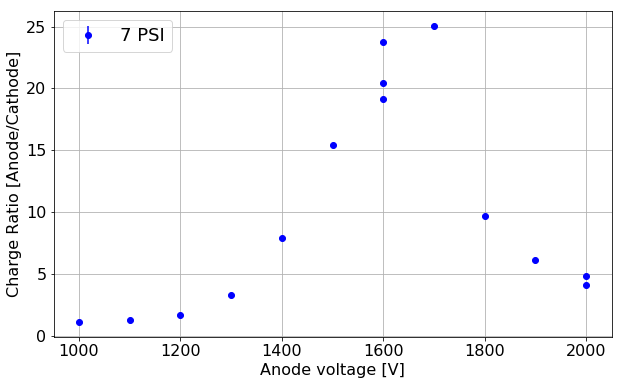

In [14]:
fig = plt.figure(figsize=(10,6))


for i,anode_voltages in enumerate(anode_voltages_v):
    
    print i
    print len(anode_voltages)
    
    #if (i != 0):
    #    continue
    
    int_an_v  = int_an_v_v[i]
    int_cat_v = int_cat_v_v[i]
    Qa_rms_v  = Qa_rms_v_v[i]
    Qa_avg_v  = Qa_avg_v_v[i]
    Qc_rms_v  = Qc_rms_v_v[i]
    Qc_avg_v  = Qc_avg_v_v[i]
    
    print len(int_an_v)

    Qa_avg_v=np.array(Qa_avg_v)
    Qc_avg_v=np.array(Qc_avg_v)
    Qa_rms_v=np.array(Qa_rms_v)
    Qc_rms_v=np.array(Qc_rms_v)
    
    #ratio=(np.array(np.abs(int_an_v))-np.array(np.abs(int_cat_v)))/np.array(np.abs(int_cat_v))
    ratio = (Qa_avg_v / Qc_avg_v) #/ np.abs(Qc_avg_v)
    #err_ratio=np.sqrt((np.array(Qa_rms_v)/(np.array(int_cat_v)))**2+(np.array(int_an_v)*np.array(Qc_rms_v)/(np.array(int_cat_v))**2)**2)
    err_ratio = np.sqrt( (Qa_rms_v/Qa_avg_v)**2 + (Qc_rms_v/Qc_avg_v)**2 )
    
    #print 'Anode voltages : ',anode_voltages
    #print 'error : ',Qc_rms_v

    if (i == 0):
        plt.errorbar(anode_voltages,ratio,yerr=err_ratio,fmt='o',color='b',markersize=6,label=label_v[i])
    #if (i == 4):
    #    plt.errorbar(anode_voltages,ratio,yerr=err_ratio,fmt='o',color='b',markersize=6)
    #if ((i!=0) and (i!=1)):
    #    plt.errorbar(anode_voltages,ratio,yerr=err_ratio,fmt='o',markersize=8,label=label_v[i])

plt.grid()
plt.legend(numpoints=1,fontsize=18, loc=2)
plt.xlabel('Anode voltage [V]',fontsize=16)
plt.ylabel('Charge Ratio [Anode/Cathode]',fontsize=16)
#plt.ylabel('Ratio delta amplitude / cathode',fontsize=16)
#plt.ylabel('Drift time [ms] [50-run avg.]',fontsize=16)
#plt.ylabel('Amplitude anode / amplitude cathode',fontsize=20)
#plt.title('Measures in GAr @ Run3, 3 psi [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Measures in LAr @ Run1, [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Drift time in LAr, [Vc = -200V, Vcg = -130V]',fontsize=16)

#fig.savefig('measures_LAr_VC100_VCG65.png')
#plt.xlim([100,1050])
#plt.ylim([0.95,1.6])
#plt.ylim([-0.4,0.4])#0.00,0.16])
#plt.xscale('log')
#plt.yscale('log')
plt.show()

In [10]:
print(Qa_rms_v)

[5.24123145e-05 6.43868526e-05 6.66160075e-05 7.77757679e-05
 7.10681633e-05 8.57167651e-05 7.30491791e-05 7.89392337e-05
 7.47205729e-05 7.38898663e-05 6.58126519e-05 6.72808664e-05
 6.85086667e-05 7.68176553e-05 6.95937146e-05 8.77012331e-05
 7.44303638e-05 7.40815259e-05 6.67135386e-05 8.30809313e-05
 8.06310787e-05 8.60259650e-05 7.90136738e-05 8.93871836e-05
 9.51655900e-05 9.43105840e-05 9.53916075e-05 9.53467462e-05
 1.01691870e-04 1.06279276e-04 1.05298284e-04 1.08530390e-04
 1.15596692e-04 1.22867970e-04 1.18931372e-04 1.42570660e-04]


In [11]:

ratio15 = [-1., -0.24668679, -0.11322492, -0.03218646, -0.00058467,  0.00227667,  0.00495479,
  0.00253999,  0.00453614,  0.0042919,   0.00324464 , 0.00371206 , 0.0047085,
  0.00513499,  0.00380238,  0.00591072,  0.00384652 , 0.00380147 , 0.00573098,
  0.00429826,  0.00738685,  0.0080153,   0.00926858 , 0.01277445 , 0.01645522,
  0.01997176,  0.0215852,   0.02366643,  0.02885677 , 0.03140749,  0.03623715,
  0.04104347,  0.04918997,  0.05822755,  0.06981644,  0.08945703]

err_ratio15=[0,0.0014047138520653494, 0.0017420234042780096, 0.001827264127014538, 0.0020222990486805682, 0.001922791107909393, 0.001869023481516259, 0.001995127081191335, 0.001903893273863286, 0.0018970986596561776, 0.001964011643485249, 0.0018990856940196805, 0.0019141599841018435, 0.001961523525386318, 0.001969136307847787, 0.0019687065171791755, 0.0018515507413195016, 0.0020179896773399653, 0.001988526603395771, 0.0018252502485274723, 0.0019163438390570353, 0.0018962516322811667, 0.0018872779222859162, 0.0020410918622035903, 0.0021009931197124958, 0.002120941667365355, 0.0020564847992617175, 0.0020947335873876954, 0.0020406113752734173, 0.0021321073266618203, 0.0022222845254233716, 0.00212720956044876, 0.002167901256932354, 0.002218347532268903, 0.002360185826384608, 0.002563392454039681]

In [12]:
fig = plt.figure(figsize=(10,4))
anode_voltages=[6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 69, 80, 90, 100, 120, 141, 161, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
plt.errorbar(anode_voltages,ratio3,yerr=err_ratio3,fmt='o',color='b',markersize=5,label='3psi')
plt.errorbar(anode_voltages,ratio7,yerr=err_ratio7,fmt='o',color='r',markersize=5,label='7psi')
plt.errorbar(anode_voltages,ratio15,yerr=err_ratio15,fmt='o',color='m',markersize=5,label='15psi')
plt.grid()
plt.legend(numpoints=1,fontsize=18, loc=4)
plt.xlabel('Anode voltage [V]',fontsize=16)
#plt.ylabel('Amplitude [mV] [50-run avg.]',fontsize=16)
plt.ylabel('Relative difference',fontsize=16)
#plt.ylabel('Drift time [ms] [50-run avg.]',fontsize=16)
#plt.ylabel('Amplitude anode / amplitude cathode',fontsize=20)
plt.title('Measures in GAr @ Run3 [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Measures in LAr @ Run1, [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Drift time in LAr, [Vc = -200V, Vcg = -130V]',fontsize=16)

#fig.savefig('measures_LAr_VC100_VCG65.png')
plt.xlim([5,1400])
plt.ylim([-0.4,0.4])#0.00,0.16])
plt.xscale('log')
plt.show()

NameError: name 'ratio3' is not defined